In [1]:
import numpy as np
import torch 
from torch import nn
from torch.nn import functional as F

import torch.optim as optim


# Data preprocessing utils : 
from torchvision.transforms import Compose
from torchvision import transforms
from torch.utils.data import DataLoader

# Visuals utils
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# my defined model
from utils.acdc_dataset import *
from utils.funcs import *
from utils.vqvae import *

In [2]:
######################## Parameters ######################

# dataset params :
L = 128  # length of input images
data_modality = 'SEG'  # either 'SEG' to use segmentation dataset or 'MRI' for gray-scale MRIs

# training params
BATCH_SIZE = 32
lr = 5e-4
epochs = 100
model_name = 'saved_models/demos/demo2.pth'


# model hyper-params :
K =  512 # num_embeddings
D =  64  # embedding_dim 
downsampling_factor = 4


use_residual = False # swicth to True if wants to use RQ-VAE
num_quantizers = 0
shared_codebook = False


# beta = 0.25
# decay = .8

kmeans_init = True
# kmeans_iters = 10


In [3]:


#################### dataset init ######################
dataset_path = "/home/ids/ihamdaoui-21/ACDC/database"

train_set_path = os.path.join(dataset_path, "training")
test_set_path  = os.path.join(dataset_path, "testing")


train_dataset = load_dataset(train_set_path, modality= data_modality)
test_dataset  = load_dataset(test_set_path, modality= data_modality)


if data_modality == 'SEG':
    input_transforms = Compose([
        transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
        One_hot_Transform(num_classes=4)
        ])
else : 
    input_transforms = Compose([
        transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
        PercentileClip(lower_percentile=1, upper_percentile=99),
        MinMaxNormalize(min_value=0.0, max_value=1.0),
        ])


TrainDataset = ACDC_Dataset(data = train_dataset, transforms= input_transforms) 
TestDataset  = ACDC_Dataset(data = test_dataset, transforms= input_transforms)

TrainLoader  = DataLoader(TrainDataset, batch_size = BATCH_SIZE, shuffle = True)
TestLoader   = DataLoader(TestDataset , batch_size = BATCH_SIZE, shuffle = False)




In [4]:

# instanciate model :

VQ_VAE =  VQVAE(embedding_dim= D,
                num_embeddings= K,
                downsampling_factor= downsampling_factor,
                # residual = use_residual,
                # num_quantizers = num_quantizers,
                # shared_codebook = shared_codebook,
                # beta = beta,
                # decay = decay,
                data_mod = data_modality,
                kmeans_init = kmeans_init,
                # kmeans_iters = kmeans_iters,
                # loss_func = loss_func
                    )

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = VQ_VAE.to(device)

optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)


In [5]:

model.train()

train_loss_values    = []
commit_loss_values   = []
val_loss_values      = []


best_val_loss = float('inf')

for epoch in range(epochs):

    train_loss  = []
    commit_loss = []

    with tqdm(enumerate(TrainLoader), unit="batch", total=len(TrainLoader)) as tepoch:
        for batch_idx, (inputs) in tepoch:
            inputs = inputs.float().to(device)  # Move data to the appropriate device (GPU/CPU)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass // args is a list containing : [output, input, vq_loss]
            output, inputs, indices, commitement_Loss = model(inputs)
            
            # Loss and backward
            all_loss = model.loss_function(output, inputs, indices, commitement_Loss)
            loss = all_loss['loss']  # Use the loss function defined in the model
            recons_loss = all_loss['Reconstruction_Loss']
            commitement_Loss = all_loss['commitement_Loss']

            loss.backward()
            optimizer.step()
                        
            # Track running loss
            train_loss.append( recons_loss.item() )
            commit_loss.append( commitement_Loss.item() )

            # tqdm bar displays the loss
            tepoch.set_postfix(loss=loss.item())

    train_loss_values.append( np.mean(train_loss))
    commit_loss_values.append( np.mean(commit_loss))

    # Validation after each epoch
    val_loss = evaluate_model(model, TestLoader, device)
    val_loss_values.append(val_loss)

    #saving model if Loss values decreases
    if val_loss < best_val_loss :
        save_model(model_name, model, epoch, train_loss_values, val_loss_values, commit_loss_values, val_loss)
        best_val_loss = val_loss

    print('Epoch {}: '.format(epoch))


print("Training complete.")

100%|██████████| 60/60 [00:06<00:00,  9.37batch/s, loss=0.33] 


Epoch 0: 


100%|██████████| 60/60 [00:04<00:00, 14.12batch/s, loss=0.108]


Epoch 1: 


100%|██████████| 60/60 [00:06<00:00,  9.98batch/s, loss=0.0475]


Epoch 2: 


100%|██████████| 60/60 [00:05<00:00, 10.25batch/s, loss=0.0629]


Epoch 3: 


100%|██████████| 60/60 [00:04<00:00, 14.73batch/s, loss=0.0403]


Epoch 4: 


100%|██████████| 60/60 [00:03<00:00, 15.32batch/s, loss=0.0339]


Epoch 5: 


100%|██████████| 60/60 [00:04<00:00, 14.51batch/s, loss=0.0343]


Epoch 6: 


100%|██████████| 60/60 [00:05<00:00, 11.52batch/s, loss=0.0282]


Epoch 7: 


100%|██████████| 60/60 [00:04<00:00, 14.50batch/s, loss=0.0322]


Epoch 8: 


100%|██████████| 60/60 [00:04<00:00, 14.58batch/s, loss=0.0276]


Epoch 9: 


100%|██████████| 60/60 [00:04<00:00, 12.92batch/s, loss=0.0294]


Epoch 10: 


100%|██████████| 60/60 [00:04<00:00, 13.38batch/s, loss=0.0282]


Epoch 11: 


100%|██████████| 60/60 [00:04<00:00, 12.87batch/s, loss=0.0311]


Epoch 12: 


100%|██████████| 60/60 [00:04<00:00, 14.37batch/s, loss=0.0294]


Epoch 13: 


100%|██████████| 60/60 [00:05<00:00, 11.86batch/s, loss=0.0313]


Epoch 14: 


100%|██████████| 60/60 [00:03<00:00, 15.07batch/s, loss=0.0352]


Epoch 15: 


100%|██████████| 60/60 [00:04<00:00, 14.96batch/s, loss=0.0332]


Epoch 16: 


100%|██████████| 60/60 [00:04<00:00, 14.61batch/s, loss=0.0261]


Epoch 17: 


100%|██████████| 60/60 [00:05<00:00, 10.23batch/s, loss=0.0255]


Epoch 18: 


100%|██████████| 60/60 [00:06<00:00,  9.82batch/s, loss=0.029] 


Epoch 19: 


100%|██████████| 60/60 [00:04<00:00, 12.99batch/s, loss=0.031] 


Epoch 20: 


100%|██████████| 60/60 [00:03<00:00, 15.25batch/s, loss=0.0346]


Epoch 21: 


100%|██████████| 60/60 [00:03<00:00, 15.40batch/s, loss=0.0314]


Epoch 22: 


100%|██████████| 60/60 [00:05<00:00, 10.81batch/s, loss=0.0306]


Epoch 23: 


100%|██████████| 60/60 [00:04<00:00, 13.66batch/s, loss=0.0279]


Epoch 24: 


100%|██████████| 60/60 [00:04<00:00, 14.91batch/s, loss=0.032] 


Epoch 25: 


100%|██████████| 60/60 [00:03<00:00, 16.21batch/s, loss=0.0265]


Epoch 26: 


100%|██████████| 60/60 [00:05<00:00, 11.51batch/s, loss=0.0301]


Epoch 27: 


100%|██████████| 60/60 [00:04<00:00, 14.60batch/s, loss=0.0251]


Epoch 28: 


100%|██████████| 60/60 [00:03<00:00, 15.00batch/s, loss=0.0296]


Epoch 29: 


100%|██████████| 60/60 [00:05<00:00, 10.17batch/s, loss=0.0362]


Epoch 30: 


100%|██████████| 60/60 [00:04<00:00, 14.50batch/s, loss=0.0286]


Epoch 31: 


100%|██████████| 60/60 [00:03<00:00, 15.96batch/s, loss=0.0296]


Epoch 32: 


100%|██████████| 60/60 [00:03<00:00, 15.03batch/s, loss=0.0304]


Epoch 33: 


100%|██████████| 60/60 [00:03<00:00, 15.95batch/s, loss=0.0271]


Epoch 34: 


100%|██████████| 60/60 [00:05<00:00, 10.55batch/s, loss=0.0289]


Epoch 35: 


100%|██████████| 60/60 [00:03<00:00, 15.89batch/s, loss=0.0334]


Epoch 36: 


100%|██████████| 60/60 [00:04<00:00, 14.93batch/s, loss=0.0326]


Epoch 37: 


100%|██████████| 60/60 [00:04<00:00, 13.56batch/s, loss=0.0299]


Epoch 38: 


100%|██████████| 60/60 [00:04<00:00, 14.84batch/s, loss=0.0301]


Epoch 39: 


100%|██████████| 60/60 [00:03<00:00, 16.15batch/s, loss=0.0228]


Epoch 40: 


100%|██████████| 60/60 [00:04<00:00, 12.05batch/s, loss=0.0356]


Epoch 41: 


100%|██████████| 60/60 [00:04<00:00, 14.61batch/s, loss=0.0265]


Epoch 42: 


100%|██████████| 60/60 [00:03<00:00, 15.26batch/s, loss=0.0273]


Epoch 43: 


100%|██████████| 60/60 [00:03<00:00, 15.46batch/s, loss=0.0297]


Epoch 44: 


100%|██████████| 60/60 [00:03<00:00, 15.57batch/s, loss=0.0271]


Epoch 45: 


100%|██████████| 60/60 [00:04<00:00, 12.84batch/s, loss=0.0235]


Epoch 46: 


100%|██████████| 60/60 [00:04<00:00, 14.23batch/s, loss=0.0248]


Epoch 47: 


100%|██████████| 60/60 [00:07<00:00,  8.48batch/s, loss=0.0303]


Epoch 48: 


100%|██████████| 60/60 [00:03<00:00, 15.48batch/s, loss=0.0289]


Epoch 49: 


100%|██████████| 60/60 [00:04<00:00, 13.55batch/s, loss=0.0295]


Epoch 50: 


100%|██████████| 60/60 [00:04<00:00, 13.57batch/s, loss=0.0257]


Epoch 51: 


100%|██████████| 60/60 [00:05<00:00, 11.46batch/s, loss=0.0235]


Epoch 52: 


100%|██████████| 60/60 [00:04<00:00, 14.35batch/s, loss=0.0319]


Epoch 53: 


100%|██████████| 60/60 [00:05<00:00, 11.83batch/s, loss=0.0262]


Epoch 54: 


100%|██████████| 60/60 [00:03<00:00, 15.63batch/s, loss=0.0255]


Epoch 55: 


100%|██████████| 60/60 [00:04<00:00, 13.18batch/s, loss=0.027] 


Epoch 56: 


100%|██████████| 60/60 [00:04<00:00, 13.24batch/s, loss=0.0328]


Epoch 57: 


100%|██████████| 60/60 [00:04<00:00, 12.62batch/s, loss=0.0271]


Epoch 58: 


100%|██████████| 60/60 [00:03<00:00, 15.32batch/s, loss=0.0261]


Epoch 59: 


100%|██████████| 60/60 [00:04<00:00, 13.19batch/s, loss=0.0344]


Epoch 60: 


100%|██████████| 60/60 [00:04<00:00, 13.84batch/s, loss=0.0263]


Epoch 61: 


100%|██████████| 60/60 [00:04<00:00, 13.86batch/s, loss=0.0316]


Epoch 62: 


100%|██████████| 60/60 [00:03<00:00, 15.89batch/s, loss=0.0297]


Epoch 63: 


100%|██████████| 60/60 [00:03<00:00, 15.75batch/s, loss=0.0235]


Epoch 64: 


100%|██████████| 60/60 [00:04<00:00, 14.73batch/s, loss=0.0297]


Epoch 65: 


100%|██████████| 60/60 [00:04<00:00, 14.47batch/s, loss=0.0303]


Epoch 66: 


100%|██████████| 60/60 [00:04<00:00, 13.65batch/s, loss=0.0267]


Epoch 67: 


100%|██████████| 60/60 [00:04<00:00, 14.14batch/s, loss=0.0284]


Epoch 68: 


100%|██████████| 60/60 [00:05<00:00, 11.53batch/s, loss=0.0268]


Epoch 69: 


100%|██████████| 60/60 [00:05<00:00, 11.75batch/s, loss=0.0271]


Epoch 70: 


100%|██████████| 60/60 [00:04<00:00, 14.42batch/s, loss=0.0257]


Epoch 71: 


100%|██████████| 60/60 [00:04<00:00, 14.46batch/s, loss=0.0259]


Epoch 72: 


100%|██████████| 60/60 [00:03<00:00, 15.04batch/s, loss=0.031] 


Epoch 73: 


100%|██████████| 60/60 [00:03<00:00, 15.18batch/s, loss=0.0267]


Epoch 74: 


100%|██████████| 60/60 [00:03<00:00, 15.13batch/s, loss=0.0242]


Epoch 75: 


100%|██████████| 60/60 [00:03<00:00, 16.05batch/s, loss=0.0308]


Epoch 76: 


100%|██████████| 60/60 [00:03<00:00, 15.28batch/s, loss=0.0257]


Epoch 77: 


100%|██████████| 60/60 [00:03<00:00, 15.37batch/s, loss=0.028] 


Epoch 78: 


100%|██████████| 60/60 [00:04<00:00, 13.08batch/s, loss=0.0242]


Epoch 79: 


100%|██████████| 60/60 [00:04<00:00, 13.95batch/s, loss=0.0313]


Epoch 80: 


100%|██████████| 60/60 [00:04<00:00, 14.83batch/s, loss=0.0278]


Epoch 81: 


100%|██████████| 60/60 [00:04<00:00, 13.30batch/s, loss=0.0294]


Epoch 82: 


100%|██████████| 60/60 [00:04<00:00, 13.62batch/s, loss=0.0291]


Epoch 83: 


100%|██████████| 60/60 [00:03<00:00, 16.00batch/s, loss=0.0273]


Epoch 84: 


100%|██████████| 60/60 [00:03<00:00, 16.38batch/s, loss=0.0259]


Epoch 85: 


100%|██████████| 60/60 [00:04<00:00, 12.50batch/s, loss=0.0321]


Epoch 86: 


100%|██████████| 60/60 [00:03<00:00, 16.23batch/s, loss=0.0251]


Epoch 87: 


100%|██████████| 60/60 [00:04<00:00, 14.99batch/s, loss=0.0257]


Epoch 88: 


100%|██████████| 60/60 [00:03<00:00, 16.88batch/s, loss=0.024] 


Epoch 89: 


100%|██████████| 60/60 [00:05<00:00, 11.86batch/s, loss=0.0282]


Epoch 90: 


100%|██████████| 60/60 [00:05<00:00, 10.92batch/s, loss=0.0242]


Epoch 91: 


100%|██████████| 60/60 [00:05<00:00, 10.72batch/s, loss=0.0313]


Epoch 92: 


100%|██████████| 60/60 [00:03<00:00, 15.12batch/s, loss=0.0273]


Epoch 93: 


100%|██████████| 60/60 [00:04<00:00, 13.09batch/s, loss=0.0192]


Epoch 94: 


100%|██████████| 60/60 [00:04<00:00, 13.53batch/s, loss=0.0261]


Epoch 95: 


100%|██████████| 60/60 [00:04<00:00, 14.48batch/s, loss=0.0242]


Epoch 96: 


100%|██████████| 60/60 [00:03<00:00, 15.09batch/s, loss=0.0202]


Epoch 97: 


100%|██████████| 60/60 [00:04<00:00, 14.52batch/s, loss=0.03]  


Epoch 98: 


100%|██████████| 60/60 [00:04<00:00, 13.66batch/s, loss=0.0244]


Epoch 99: 
Training complete.


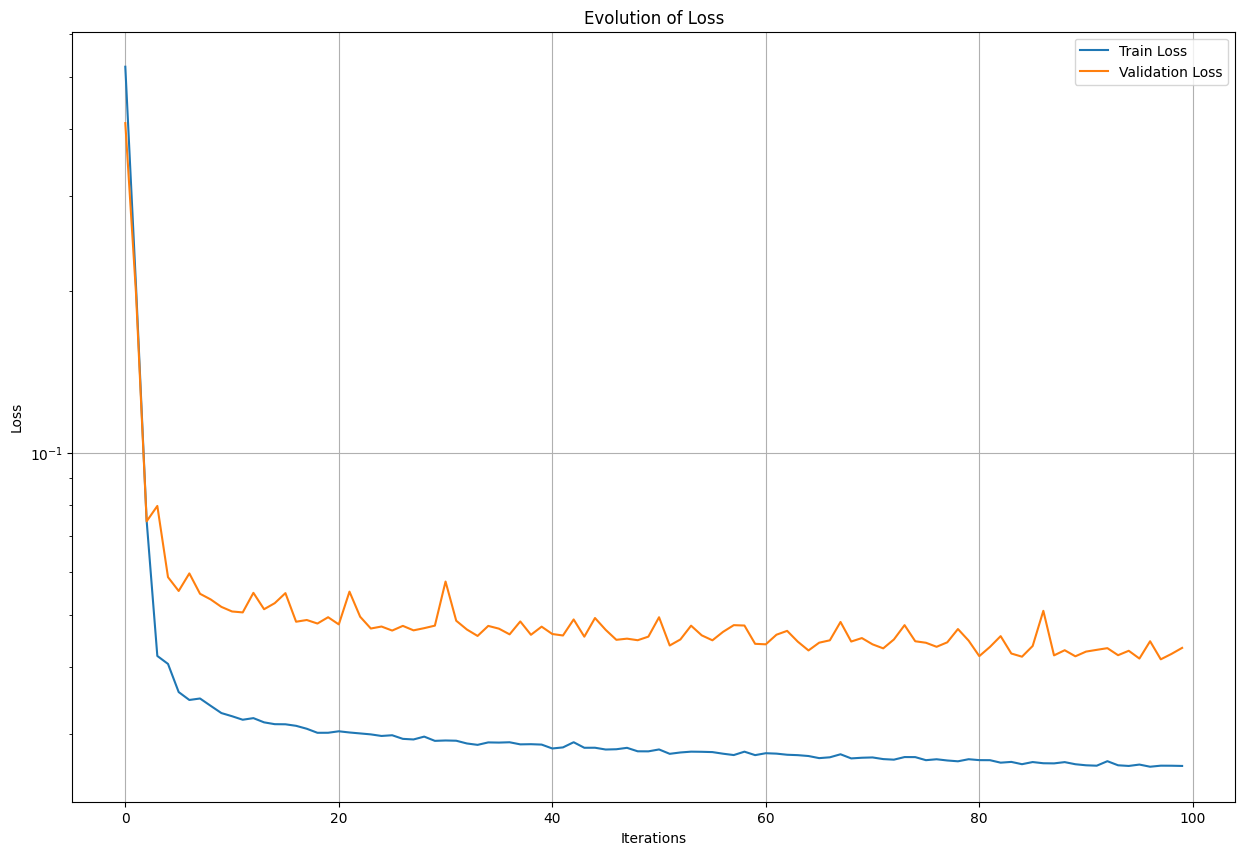

In [6]:
plot_train_val_loss(train_loss_values, val_loss_values)

## Test model

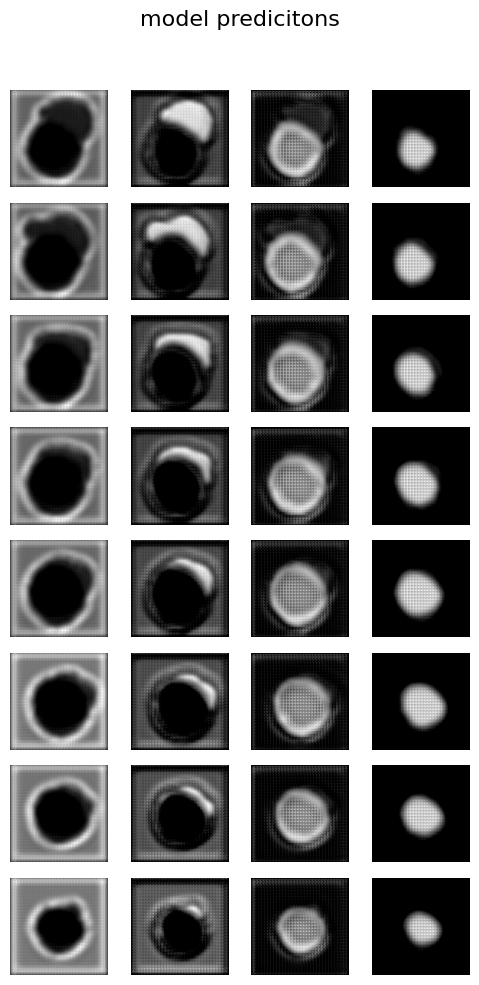

In [7]:
vis_batch = next(iter(TestLoader)).to(device)

batch_hat = reconstruct_logits(vis_batch, model)

visualize_batch_logits( batch_hat.detach().cpu(), title = "model predicitons")

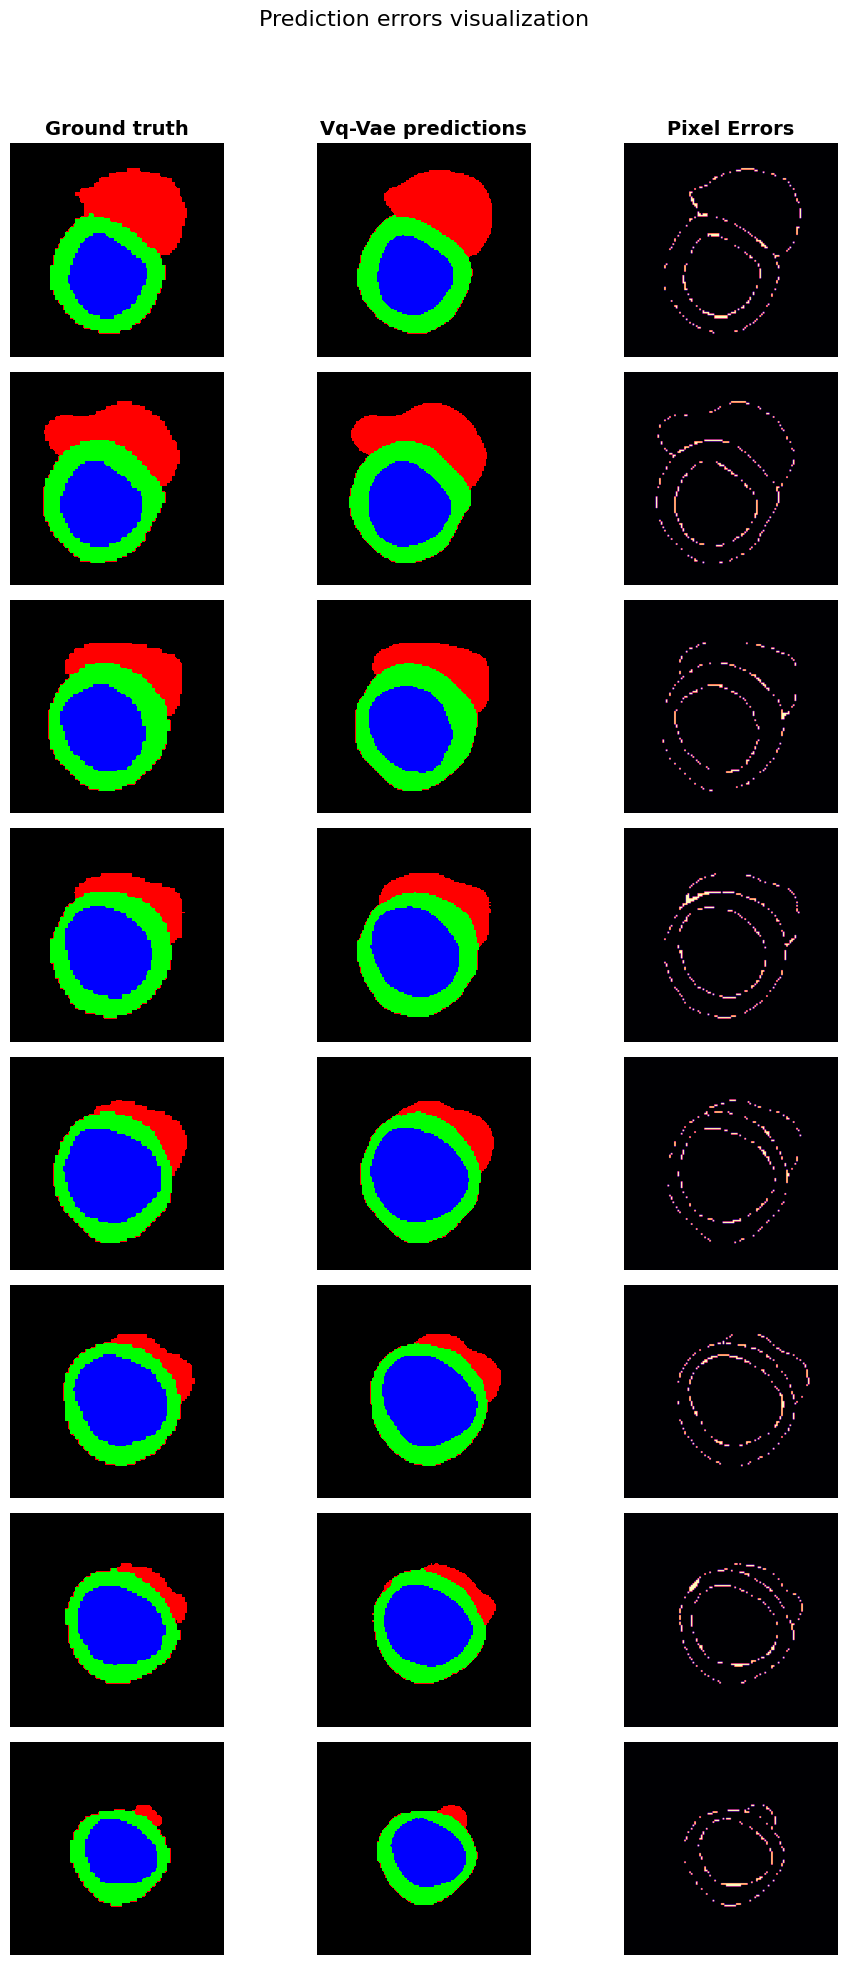

In [8]:

batch_hat = reconstruct_logits(vis_batch, model)
probs = F.softmax(batch_hat, dim=1) 

pred_seg = torch.argmax(probs,     dim=1).detach().cpu()
true_seg = torch.argmax(vis_batch, dim=1).detach().cpu()

visualize_errors(true_seg, pred_seg, 'Prediction errors visualization')

## Evaluate model score : 

In [9]:
model_path = 'saved_models/demos/demo1.pth'

model =  VQVAE(embedding_dim= D,
                num_embeddings= K,
                downsampling_factor= downsampling_factor,
                # residual = use_residual,
                # num_quantizers = num_quantizers,
                # shared_codebook = shared_codebook,
                # beta = beta,
                # decay = decay,
                # data_mod = data_modality
                    )

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model = model.to(device)

/tmp/ipykernel_2989816/886035729.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)['model_state_dict'])


In [10]:
checkpoint = torch.load(model_path)

# Extract and print all parameters
print("Checkpoint Parameters:")
print("-" * 30)
print(f"Epoch: {checkpoint['epoch']}")
print(f"K (Codebook Size): {checkpoint['K']}")
print(f"D (Codebook Dimension): {checkpoint['D']}")
print(f"Train Loss Values: {checkpoint['train_loss_values']}")
print(f"Validation Loss Values: {checkpoint['val_loss_values']}")
print(f"Codebook Loss Values: {checkpoint['codebook_loss_values']}")
# print(f"Codebook: {checkpoint['codebook']}")


Checkpoint Parameters:
------------------------------
Epoch: 83
K (Codebook Size): 512
D (Codebook Dimension): 64
Train Loss Values: [0.48984544798731805, 0.14104392230510712, 0.08425729442387819, 0.071240904306372, 0.06644036155194044, 0.06254258124778668, 0.06181606731067101, 0.058953178798158964, 0.057912314372758074, 0.056506455317139624, 0.05539288092404604, 0.054143885460992656, 0.053641507091621556, 0.05266180187463761, 0.051341331005096434, 0.051052043586969374, 0.05028947635243337, 0.04972110101953149, 0.049240233935415746, 0.047890968682865305, 0.04891609568148851, 0.047340666564802326, 0.04706350242098172, 0.04801120087504387, 0.0471246803800265, 0.04656969352314869, 0.0469180659390986, 0.04558184171716372, 0.045723909977823496, 0.04551021109024684, 0.045032401010394095, 0.044571187471350034, 0.04543835415194432, 0.0449899231394132, 0.04437451772391796, 0.04406528938561678, 0.044136029792328675, 0.04368343536431591, 0.044354514715572196, 0.04331927169114351, 0.04345553570116

/tmp/ipykernel_2989816/3513098570.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [11]:
print(score_model(model, TestLoader, device))

0.9361098005491144


### CodeBook usage :

In [12]:
hist, perc = codebook_hist_testset(model, TestLoader, device)
hist = hist/np.sum(hist)
print(perc)

ONLY 19 OF CODES WERE USED FROM 512, WHICH MAKE 3.7109375 % OF CODES FROM THE CODE-BOOK
3.7109375


In [13]:
num_codebooks = len(model.vq_layer.codebook_sizes)
size_codebook = model.vq_layer.codebook_sizes[0]

fig, axs = plt.subplots(num_codebooks,1, figsize=(15, 7))

unused_codes_list = []
for i, hist_i in enumerate(hist):

    axs[i].bar(np.arange(size_codebook), hist_i*100)
    axs[i].set_title(f'Codebook {i+1}')
    axs[i].set_xlabel('Code index')
    axs[i].set_ylabel('Usage count (%)')

plt.tight_layout()
plt.show()

AttributeError: 'VectorQuantize' object has no attribute 'codebook_sizes'